In [270]:
import xml.etree.ElementTree as ET
import pandas as pd


# parse export.xml
tree = ET.parse('export.xml')
root = tree.getroot()
# only get records of workouts
record_list = []
for workout_record in root.iter('Workout'):
    metadata = workout_record.findall('MetadataEntry')
    statistics = workout_record.findall('WorkoutStatistics')
    additional_stats = {}
    
    for metadata_entry in metadata:
        if metadata_entry.attrib['key'] == 'HKTimeZone':
            additional_stats['timeZone'] = metadata_entry.attrib['value']
    for stat in statistics:
        if stat.attrib['type'] == 'HKQuantityTypeIdentifierActiveEnergyBurned':
            additional_stats['activeCals'] = stat.attrib['sum']
        elif stat.attrib['type'] == 'HKQuantityTypeIdentifierBasalEnergyBurned':
            additional_stats['restingCals'] = stat.attrib['sum']
        elif stat.attrib['type'] == 'HKQuantityTypeIdentifierHeartRate':
            additional_stats['avgHR'] = stat.attrib['average']
            additional_stats['minHR'] = stat.attrib['minimum']
            additional_stats['maxHR'] = stat.attrib['maximum']
    
    final_record = workout_record.attrib | additional_stats
    record_list.append(final_record)

In [271]:
records = pd.DataFrame(record_list)
# remove long names

records['workoutActivityType']= records['workoutActivityType'].str.replace('HKWorkoutActivityType','')
# drop unneeded columns
# note that durationUnit is always in mins
records.drop(['sourceName','sourceVersion', 'creationDate','durationUnit', 'device'],axis=1,inplace=True)

# convert dates to datetime
records[['startDate','endDate']] = records[['startDate','endDate']].apply(lambda date:pd.to_datetime(date))

# this record just looked very weird in my set so i deleted it
records.drop(0,inplace=True)

# convert to numerics
records[['duration','restingCals',
         'avgHR','minHR',
         'maxHR','activeCals']] = records[['duration','restingCals',
                                           'avgHR','minHR',
                                           'maxHR','activeCals']].apply(pd.to_numeric)

print(records.head())

           workoutActivityType   duration                 startDate  \
1                         Yoga  22.553774 2024-01-18 13:11:41-04:00   
2                         Yoga  18.617671 2024-01-19 23:33:42-04:00   
3                      Walking   6.748169 2024-01-20 18:18:30-04:00   
4                      Walking  19.577287 2024-01-20 19:46:46-04:00   
5  TraditionalStrengthTraining  52.533711 2024-01-20 20:06:27-04:00   

                    endDate           timeZone  restingCals    avgHR  minHR  \
1 2024-01-18 13:34:14-04:00  America/Vancouver      28.5226  123.170     95   
2 2024-01-19 23:52:19-04:00  America/Vancouver      23.5440  115.669     77   
3 2024-01-20 18:25:15-04:00  America/Vancouver       8.3700  112.120    100   
4 2024-01-20 20:06:21-04:00  America/Vancouver      24.2733  123.970    107   
5 2024-01-20 20:58:59-04:00  America/Vancouver      64.8119  147.323    103   

   maxHR  activeCals  
1    162     99.7136  
2    155     72.1290  
3    140     23.4690  
4    1

In [272]:
'''
    We need to convert the record back to its respective timezone.
    When you move to another time zone, Apple automatically transforms
    your records into the new time zone.

    For example, if you do a workout at 7pm in Vancouver, then two
    months later you move to Toronto, your workout will now show up
    as being at 10pm. 

    This screws up my analytics - I want to know whether I worked
    out at 7pm. I don't care about time zone!

    It should be noted there is a time zone in these records, 
    so the conversion itself is easy. We just need to loop 
    through to figure out what timezone to convert back to.
'''

records['startDate'] = records.apply(lambda x: x['startDate'].tz_convert(x['timeZone']),axis=1)
records['endDate'] = records.apply(lambda x: x['endDate'].tz_convert(x['timeZone']),axis=1)
    
# drop timezone column as we don't need anymore
records = records.drop('timeZone',axis=1)

# we have to convert this to a python datetime
# or else the weekday functions don't work.
records['startDate'] = records['startDate'].apply(lambda date:date.to_pydatetime())
records['endDate'] = records['endDate'].apply(lambda date:date.to_pydatetime())
print(records.head())

           workoutActivityType   duration                  startDate  \
1                         Yoga  22.553774  2024-01-18 09:11:41-08:00   
2                         Yoga  18.617671  2024-01-19 19:33:42-08:00   
3                      Walking   6.748169  2024-01-20 14:18:30-08:00   
4                      Walking  19.577287  2024-01-20 15:46:46-08:00   
5  TraditionalStrengthTraining  52.533711  2024-01-20 16:06:27-08:00   

                     endDate  restingCals    avgHR  minHR  maxHR  activeCals  
1  2024-01-18 09:34:14-08:00      28.5226  123.170     95    162     99.7136  
2  2024-01-19 19:52:19-08:00      23.5440  115.669     77    155     72.1290  
3  2024-01-20 14:25:15-08:00       8.3700  112.120    100    140     23.4690  
4  2024-01-20 16:06:21-08:00      24.2733  123.970    107    149     62.7400  
5  2024-01-20 16:58:59-08:00      64.8119  147.323    103    189    327.4610  


In [273]:
# WHO WANTS FEATURE ENGINEERING?
# I DOOOOO!!!!! MEMEMEMEMEME!!!!!! MEEEEEE!!!!!

# create total cal column
records['totalCals'] = records['restingCals'] + records['activeCals']

# create weekday column - note it is based on the start date.
# the end date MAY be another day because I track my clubbing
# as a social dance on my apple watch. but i dont think that's relevant
records['weekDay'] = records['startDate'].apply(lambda x:x.strftime("%A"))

# split hours and minutes into its own column
records['startHour'] = records['startDate'].apply(lambda x:x.strftime('%H'))
records['startMinutes'] = records['startDate'].apply(lambda x:x.strftime('%M'))
records['endHour'] = records['endDate'].apply(lambda x:x.strftime('%H'))
records['endMinutes'] = records['endDate'].apply(lambda x:x.strftime('%M'))

# clean the start & end date columns to only show dates now that we have the hour+minutes
records['startDate'] = records['startDate'].apply(lambda x:x.strftime('%Y-%m-%d'))
records['endDate'] = records['endDate'].apply(lambda x:x.strftime('%Y-%m-%d'))

print(records.head())

           workoutActivityType   duration   startDate     endDate  \
1                         Yoga  22.553774  2024-01-18  2024-01-18   
2                         Yoga  18.617671  2024-01-19  2024-01-19   
3                      Walking   6.748169  2024-01-20  2024-01-20   
4                      Walking  19.577287  2024-01-20  2024-01-20   
5  TraditionalStrengthTraining  52.533711  2024-01-20  2024-01-20   

   restingCals    avgHR  minHR  maxHR  activeCals  totalCals   weekDay  \
1      28.5226  123.170     95    162     99.7136   128.2362  Thursday   
2      23.5440  115.669     77    155     72.1290    95.6730    Friday   
3       8.3700  112.120    100    140     23.4690    31.8390  Saturday   
4      24.2733  123.970    107    149     62.7400    87.0133  Saturday   
5      64.8119  147.323    103    189    327.4610   392.2729  Saturday   

  startHour startMinutes endHour endMinutes  
1        09           11      09         34  
2        19           33      19         52  
3 

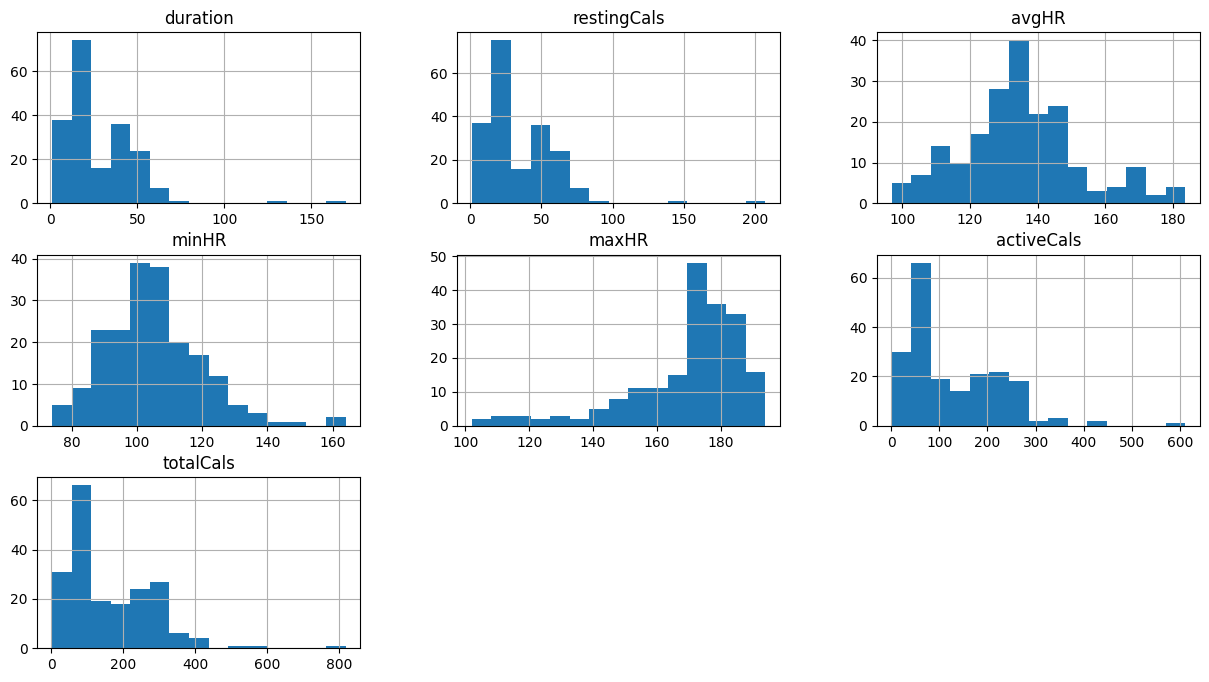

In [274]:
# VISUALIZE TIME!!!!!
import matplotlib.pyplot as plt
# plot a basic histogram
records.hist(bins=15, figsize=(15, 8))
plt.show()

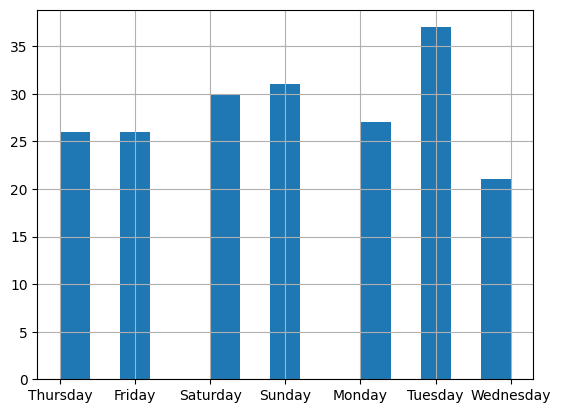

In [275]:
# plot histogram of exercises per weekday
records['weekDay'].hist(bins=15)
plt.show()

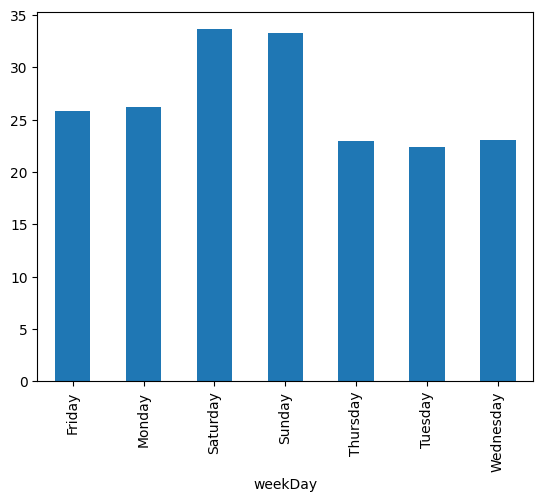

In [276]:
# display avg exercise duration per weekday
records.groupby(['weekDay'])['duration'].mean().plot.bar(x='weekDay',y='duration')
plt.show()

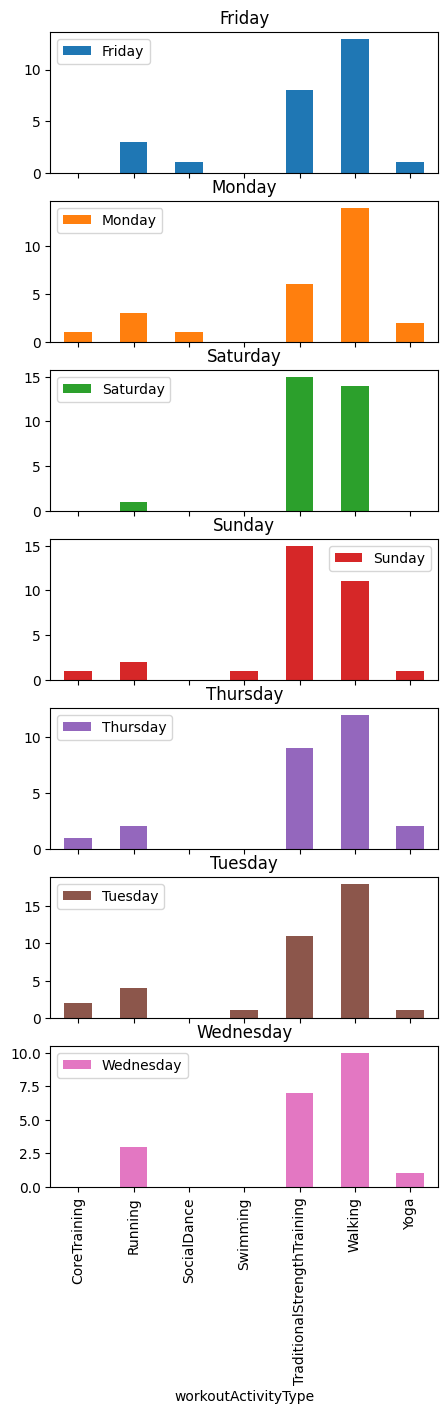

In [277]:
# display num of workouts per weekday
pd.crosstab(records['workoutActivityType'], records['weekDay']).plot.bar(subplots=True,figsize=(5,15))
plt.show()

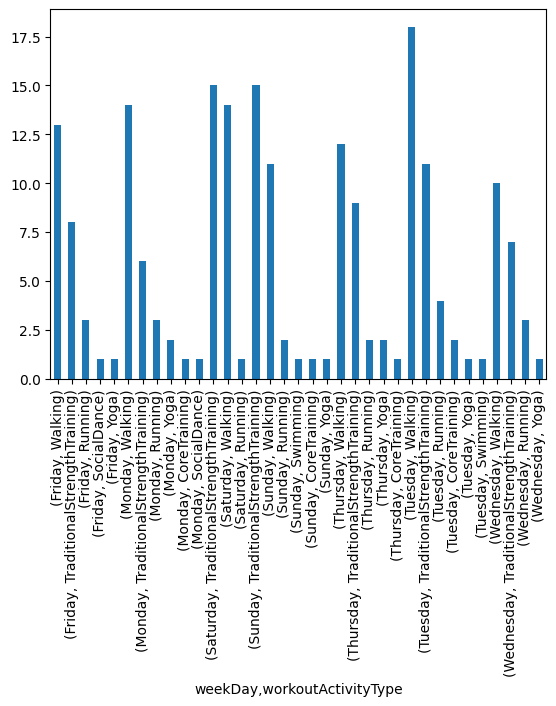

In [278]:
# another alternative view
records.groupby('weekDay')['workoutActivityType'].value_counts().plot.bar()
plt.show()

In [279]:
# time to nerd out!

# drop the start and end dates, we don't really need them and theyre just noise
records = records.drop(['startDate','endDate','endHour','endMinutes'],axis=1)
# split the training and test set
training_data = records.drop('workoutActivityType',axis=1)
training_labels = records['workoutActivityType'].copy()

In [280]:
# transform the training set
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_feat = ['duration','restingCals', 'avgHR', 'minHR',
            'maxHR','activeCals', 'totalCals','startHour','startMinutes']

cat_feat = ['weekDay']

# pipeline for numerical vals
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("standardize", StandardScaler())])

# pipeline for categorical vals
cat_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                         ("encode",OneHotEncoder(handle_unknown='ignore'))])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_feat),
    ("cat", cat_pipeline, cat_feat),
    ],remainder='passthrough')


transformed_training_data = preprocessing.fit_transform(training_data)
preprocessing.get_feature_names_out()

array(['num__duration', 'num__restingCals', 'num__avgHR', 'num__minHR',
       'num__maxHR', 'num__activeCals', 'num__totalCals',
       'num__startHour', 'num__startMinutes', 'cat__weekDay_Friday',
       'cat__weekDay_Monday', 'cat__weekDay_Saturday',
       'cat__weekDay_Sunday', 'cat__weekDay_Thursday',
       'cat__weekDay_Tuesday', 'cat__weekDay_Wednesday'], dtype=object)

In [281]:
# predict whether a workout was strength training or not
train_label_strength = (training_labels == 'TraditionalStrengthTraining')

In [282]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(transformed_training_data, train_label_strength)

SGDClassifier(random_state=42)

In [283]:
# lets check accuracy
from sklearn.model_selection import cross_val_score
import numpy as np
accuracy = cross_val_score(sgd_clf, transformed_training_data, train_label_strength, cv=10, scoring="accuracy")
accuracy
mean_accuracy = np.mean(accuracy)
mean_accuracy

0.8689473684210526

In [284]:
# thats actually pretty good!
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score,recall_score

train_labels_predict = cross_val_predict(sgd_clf, transformed_training_data, train_label_strength, cv=10)
cm = confusion_matrix(train_label_strength, train_labels_predict)
print(cm)
precision = precision_score(train_label_strength, train_labels_predict)
recall = recall_score(train_label_strength, train_labels_predict)
print(precision,recall)

[[114  13]
 [ 13  58]]
0.8169014084507042 0.8169014084507042


In [285]:
# thats cool lets see if we can predict multiclass now
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(transformed_training_data, training_labels)

SGDClassifier(random_state=42)

In [286]:
accuracy = cross_val_score(sgd_clf, transformed_training_data, training_labels, cv=10, scoring="accuracy")
mean_accuracy = np.mean(accuracy)
mean_accuracy

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


0.7931578947368422

[[ 0  0  0  0  0  5  0]
 [ 0 13  0  0  0  5  0]
 [ 0  0  0  0  1  1  0]
 [ 0  0  0  0  0  2  0]
 [ 0  0  0  0 61  8  2]
 [ 2  0  0  1  8 80  1]
 [ 0  0  0  0  2  3  3]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


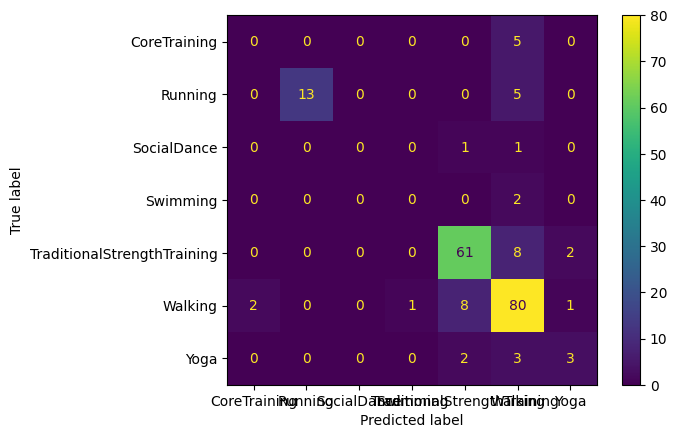

In [287]:
# ok a little worse
# lets see the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
train_labels_predict = cross_val_predict(sgd_clf, transformed_training_data, training_labels, cv=10)
cm = confusion_matrix(training_labels, train_labels_predict)
print(cm)
ConfusionMatrixDisplay.from_predictions(training_labels, train_labels_predict)

In [288]:
from sklearn.model_selection import train_test_split
# that actually is super accurate!
# but for funsies maybe we'll try a neural network?

# retrieve features and outputs for neural net

# first we have to remove some of the data without a ton of entries 
# to not throw off the train_test_split - if there arent many entries
# theres a solid chance it wont end up in the right place.
records = records.groupby('workoutActivityType').filter(lambda x: len(x) > 10)

# i need to do more workouts!
print(records['workoutActivityType'].value_counts())

# split the data
train_set, test_set = train_test_split(records, test_size=0.2, random_state=42)

X_train = train_set.drop('workoutActivityType',axis=1)
Y_train = train_set['workoutActivityType'].copy()

X_test = test_set.drop('workoutActivityType',axis=1)
Y_test = test_set['workoutActivityType'].copy()

# re-process the data
X_train_prep = preprocessing.fit_transform(X_train)
print(preprocessing.get_feature_names_out())

workoutActivityType
Walking                        92
TraditionalStrengthTraining    71
Running                        18
Name: count, dtype: int64
['num__duration' 'num__restingCals' 'num__avgHR' 'num__minHR' 'num__maxHR'
 'num__activeCals' 'num__totalCals' 'num__startHour' 'num__startMinutes'
 'cat__weekDay_Friday' 'cat__weekDay_Monday' 'cat__weekDay_Saturday'
 'cat__weekDay_Sunday' 'cat__weekDay_Thursday' 'cat__weekDay_Tuesday'
 'cat__weekDay_Wednesday']


In [289]:
import torch
# import torch.nn as nn
# import torch.optim as optim

X = torch.tensor(X_train_prep,dtype=torch.float32)

# convert the labels into codes so we can make it into a tensor
y = torch.tensor(pd.Categorical(Y_train).codes,dtype=int)


features = X.shape[1]
outputs = len(Y_train.unique())
hidden_size = 15
learning_rate = 0.01
epochs = 1000

# change labels into one-hot encodings to avoid unintentional ranking/association
Y = torch.zeros(y.size(0), outputs)
Y[torch.arange(y.size(0)), y] = 1

# create new model 
W1 = torch.randn(features, hidden_size, requires_grad=True)
b1 = torch.zeros(hidden_size, requires_grad=True)
W2 = torch.randn(hidden_size, outputs, requires_grad=True)
b2 = torch.zeros(outputs, requires_grad=True)

costs = []

for epoch in range(epochs):
    Z_1 = X.mm(W1) + b1
    A_1 = torch.sigmoid(Z_1)
    Z_2 = A_1.mm(W2) + b2
    A_2 = torch.softmax(Z_2, dim=1)

    # cost
    log_likelihood = -torch.sum(Y * torch.log(A_2)) / y.size(0)
    cost = log_likelihood
    costs.append(cost.item())

    cost.backward()
    # update parameters
    with torch.no_grad():
        W1 -= learning_rate * W1.grad
        b1 -= learning_rate * b1.grad
        W2 -= learning_rate * W2.grad
        b2 -= learning_rate * b2.grad

        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
    
    if epoch % 100 == 0:
        print(f'epoch {epoch}, cost:{cost.item()}')


Epoch 0, Cost:1.6824145317077637
Epoch 100, Cost:0.9722554087638855
Epoch 200, Cost:0.7768391370773315
Epoch 300, Cost:0.6846714019775391
Epoch 400, Cost:0.6301050186157227
Epoch 500, Cost:0.5930521488189697
Epoch 600, Cost:0.5656121969223022
Epoch 700, Cost:0.544115424156189
Epoch 800, Cost:0.5265976190567017
Epoch 900, Cost:0.51188725233078


In [290]:
# check accuracy
# first transform x test
X_test_prep = preprocessing.transform(X_test)

In [291]:
X_train = torch.tensor(X_train_prep,dtype=torch.float32)
X_test = torch.tensor(X_test_prep,dtype=torch.float32)
# convert the labels into codes so we can make it into a tensor
y_train = torch.tensor(pd.Categorical(Y_train).codes,dtype=int)
y_test = torch.tensor(pd.Categorical(Y_test).codes,dtype=int)


# check accuracy on test set
with torch.no_grad():
    # Evaluate accuracy on the training set
    Z1_train = X_train.mm(W1) + b1
    A1_train = torch.sigmoid(Z1_train)
    Z2_train = A1_train.mm(W2) + b2
    A2_train = torch.softmax(Z2_train, dim=1)
    
    predictions_train = torch.argmax(A2_train, dim=1)
    
    # get accuracy on training set
    accuracy_train = torch.mean((predictions_train == y_train).float()) * 100
    print(f'accuracy on the training set: {accuracy_train.item()}%')

    # now try on the test set
    Z1_test = X_test.mm(W1) + b1
    A1_test = torch.sigmoid(Z1_test)
    Z2_test = A1_test.mm(W2) + b2
    A2_test = torch.softmax(Z2_test, dim=1)
    
    predictions_test = torch.argmax(A2_test, dim=1)
    
    accuracy_test = torch.mean((predictions_test == y_test).float()) * 100
    print(f'accuracy on the test set: {accuracy_test.item()}%')

accuracy on the training set: 81.94444274902344%
accuracy on the test set: 86.48648834228516%
